In [1]:
! pip install numpy matplotlib opencv-python scikit-learn scikit-image tensorflow keras pandas seaborn tqdm mtcnn lz4 facenet_pytorch xgboost

In [2]:
import numpy as np
from utils import canny, load_fer2013_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Linear models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso

# Tree-based models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# SVM models
from sklearn.svm import LinearSVC, SVC

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from skimage.feature import hog , local_binary_pattern 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import cv2
from facenet_pytorch import MTCNN
import lz4 


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 

d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X, y, emotion_labels = load_fer2013_data('data/train')
print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Emotion labels: {emotion_labels}")

Loading and preprocessing images...
Processing angry: 3995 images


Loading angry: 100%|██████████| 3995/3995 [00:00<00:00, 4948.19it/s]


Processing disgust: 436 images


Loading disgust: 100%|██████████| 436/436 [00:00<00:00, 5298.52it/s]


Processing fear: 4097 images


Loading fear: 100%|██████████| 4097/4097 [00:00<00:00, 4913.52it/s]


Processing happy: 7215 images


Loading happy: 100%|██████████| 7215/7215 [00:01<00:00, 4771.15it/s]



Processing sad: 4830 images


Loading sad: 100%|██████████| 4830/4830 [00:00<00:00, 5278.14it/s]


Processing surprise: 3171 images


Loading surprise: 100%|██████████| 3171/3171 [00:00<00:00, 5200.34it/s]


Processing neutral: 4965 images


Loading neutral: 100%|██████████| 4965/4965 [00:01<00:00, 4946.10it/s]



Dataset shape: (28709, 48, 48)
Labels shape: (28709,)
Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [4]:
#  logistic regression , SVM , Decision Tree , Random Forest 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(max_iter=1000) , 
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

In [5]:
# Detailed evaluation and visualization

def evaluate_models(model_results, y_test, emotion_labels):
    """
    Detailed evaluation of all trained models
    """
    print("\n" + "=" * 60)
    print("DETAILED MODEL EVALUATION")
    print("=" * 60)
    
    # Extract results
    model_names = list(model_results.keys())
    accuracies = [model_results[name]['accuracy'] for name in model_names]
    
    # 1. Accuracy comparison plot
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    colors = ['blue', 'green', 'red', 'orange']
    bars = plt.bar(model_names, accuracies, color=colors, alpha=0.7)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # 2. Precision, Recall, F1 comparison
    plt.subplot(1, 3, 2)
    metrics_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        metrics_data.append([
            report['macro avg']['precision'],
            report['macro avg']['recall'],
            report['macro avg']['f1-score']
        ])
    
    metrics_data = np.array(metrics_data)
    x = np.arange(len(model_names))
    width = 0.25
    
    plt.bar(x - width, metrics_data[:, 0], width, label='Precision', alpha=0.7)
    plt.bar(x, metrics_data[:, 1], width, label='Recall', alpha=0.7)
    plt.bar(x + width, metrics_data[:, 2], width, label='F1-Score', alpha=0.7)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Macro-averaged Metrics')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    
    # 3. Summary table
    plt.subplot(1, 3, 3)
    summary_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        summary_data.append([
            name[:10] + '...' if len(name) > 10 else name,
            f"{model_results[name]['accuracy']:.3f}",
            f"{report['macro avg']['f1-score']:.3f}"
        ])
    
    plt.axis('tight')
    plt.axis('off')
    table = plt.table(cellText=summary_data,
                     colLabels=['Model', 'Accuracy', 'F1-Score'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Results Summary')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification reports
    for model_name, result in model_results.items():
        print(f"\n{model_name.upper()} - Classification Report:")
        print("-" * 50)
        print(classification_report(y_test, result['predictions'], target_names=emotion_labels))


In [6]:
# Save the best model and create final summary

def save_best_model(model_results, emotion_labels):
    """
    Save the best performing model and create final summary
    """
    import joblib
    
    # Find best model
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
    best_model = model_results[best_model_name]['model']
    best_accuracy = model_results[best_model_name]['accuracy']
    
    # Create summary DataFrame
    summary_data = []
    for model_name, result in model_results.items():
        summary_data.append({
            'Model': model_name,
            'Accuracy': result['accuracy'],
            'Precision_macro': result['classification_report']['macro avg']['precision'],
            'Recall_macro': result['classification_report']['macro avg']['recall'],
            'F1_macro': result['classification_report']['macro avg']['f1-score']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Accuracy', ascending=False)
    
    print("\n" + "=" * 60)
    print("FINAL BASELINE RESULTS SUMMARY")
    print("=" * 60)
    print(summary_df.round(4).to_string(index=False))
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    
    # Package everything for saving
    model_package = {
        'best_model': best_model,
        'best_model_name': best_model_name,
        'emotion_labels': emotion_labels,
        'all_results': model_results,
        'summary': summary_df,
        'target_size': (48, 48)
    }
    
    # Save to file
    joblib.dump(model_package, 'data/baseline_emotion_models.pkl')
    print(f"\nAll models and preprocessing components saved to 'baseline_emotion_models.pkl'")
    
    return summary_df, best_model_name



## 1. Dataset & Split
- Dataset: FER2013 / RAF-DB (7 lớp cảm xúc).
- Input: ảnh khuôn mặt đã crop.
- Chia tập: Train 70% – Val 15% – Test 15% (stratified).
---
## 2. Meadian filer + CLAHE 
---
## 3. Resize + Normalize
---
## 4. Feature Extraction 
  - HOG 
  - LBP 
  - SIFT
---
## 5. Model Training
- Classifier: **SVM-RBF** , **Random Forest** , **Logistic Regression** , 
---
## 6. Evaluation
- **Chỉ số chính**: Macro-F1.
- Phụ: Accuracy, per-class F1, Confusion matrix.
- Phân tích lỗi: fear ↔ surprise, disgust ↔ sad/angry.



## Preprocessing 
- CLAHE 
- Meadian Filter 
- GF, ER , MR 

In [7]:
def plot_transformation_comparison(X_original, X_transformed, transformation_name, 
                                 emotion_labels, y, n_samples=8, figsize=(20, 8)):
    """
    Universal function to plot comparison between original and transformed images
    
    Parameters:
    - X_original: Original images
    - X_transformed: Transformed images  
    - transformation_name: Name of the transformation (e.g., "CLAHE", "Median Filter")
    - emotion_labels: List of emotion labels
    - y: Label array
    - n_samples: Number of samples to display
    - figsize: Figure size
    """
    # Randomly select some indices for visualization
    indices = np.random.choice(len(X_original), n_samples, replace=False)
    
    fig, axes = plt.subplots(2, n_samples, figsize=figsize)
    
    for i, idx in enumerate(indices):
        # Original image
        orig_img = X_original[idx]
        
        # Handle different data ranges for display
        if orig_img.max() <= 1.0:
            orig_vmin, orig_vmax = 0, 1
        else:
            orig_vmin, orig_vmax = 0, 255
            
        axes[0, i].imshow(orig_img, cmap='gray', vmin=orig_vmin, vmax=orig_vmax)
        axes[0, i].set_title(f'Original\n{emotion_labels[y[idx]]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Transformed image
        trans_img = X_transformed[idx]
        
        # Handle different data ranges for display
        if trans_img.max() <= 1.0:
            trans_vmin, trans_vmax = 0, 1
        else:
            trans_vmin, trans_vmax = 0, 255
            
        axes[1, i].imshow(trans_img, cmap='gray', vmin=trans_vmin, vmax=trans_vmax)
        axes[1, i].set_title(f'{transformation_name}\n{emotion_labels[y[idx]]}', fontsize=10)
        axes[1, i].axis('off')
    
    plt.suptitle(f'Original vs {transformation_name} Enhanced Images', fontsize=16)
    plt.tight_layout()
    plt.show()


In [8]:
X_median_filtered = np.array([cv2.medianBlur(img, 3) for img in X])  


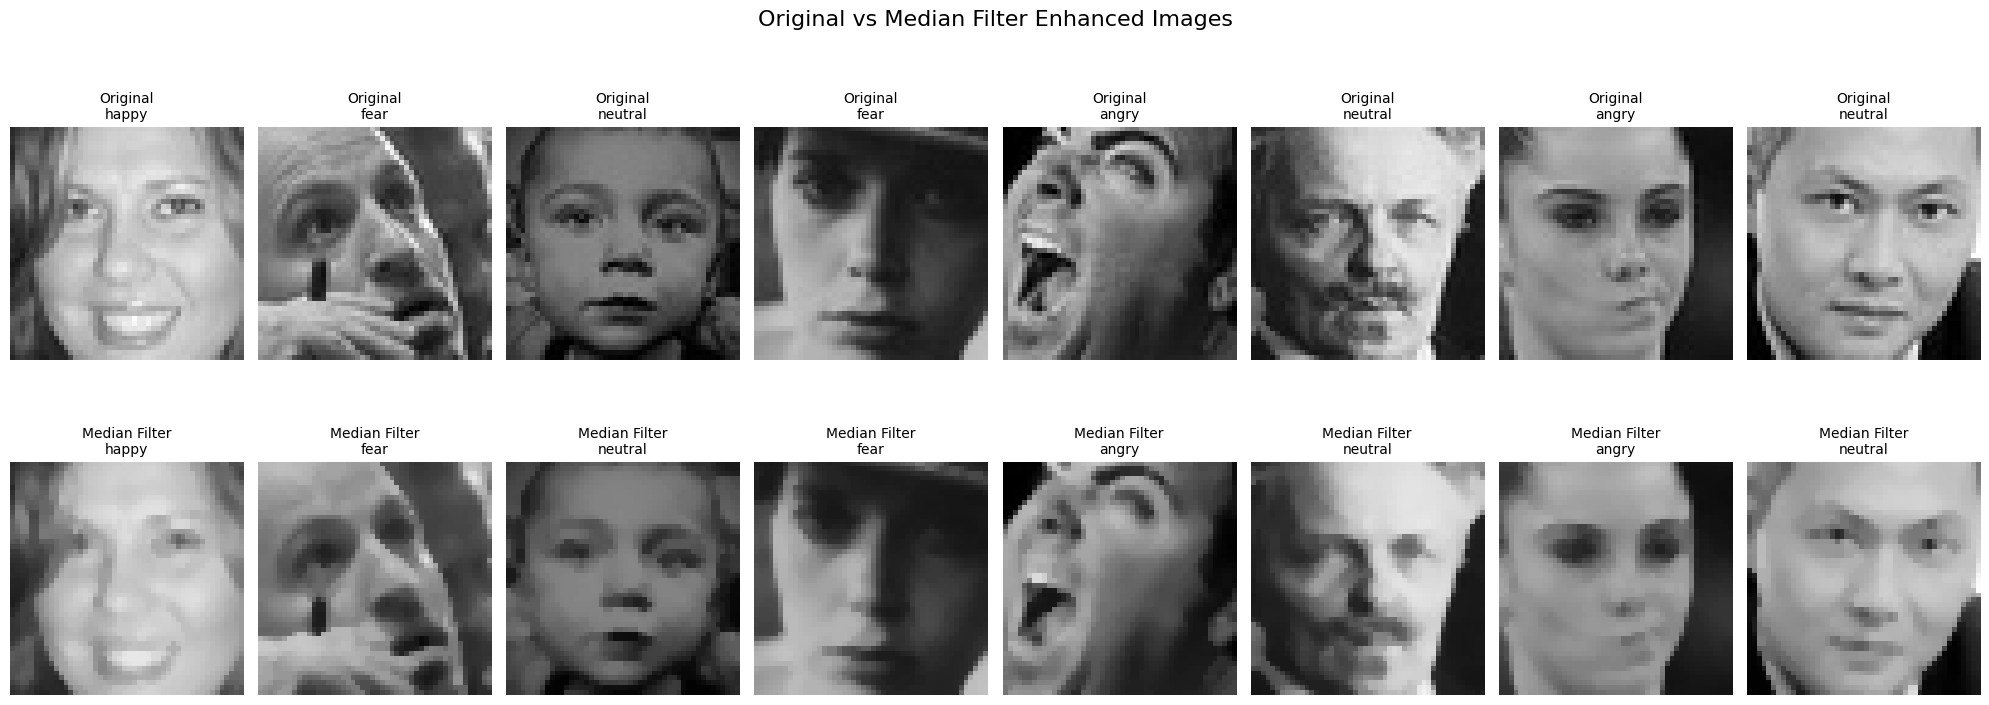

In [9]:
plot_transformation_comparison(X, X_median_filtered, "Median Filter", emotion_labels, y, n_samples=8)

In [10]:
# Apply clahe to enhance image contrast
def apply_clahe(X, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance image contrast
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_images = []
    
    print("Applying CLAHE to images...")
    for img in tqdm(X):
        # Convert to uint8 if needed
        if img.dtype != np.uint8:
            # Normalize to 0-255 range if needed
            if img.max() <= 1.0:  # If image is in [0,1] range
                img_uint8 = (img * 255).astype(np.uint8)
            else:  # If image is already in [0,255] range but wrong dtype
                img_uint8 = np.clip(img, 0, 255).astype(np.uint8)
        else:
            img_uint8 = img
        
        # Apply CLAHE
        img_enhanced = clahe.apply(img_uint8)
        enhanced_images.append(img_enhanced)
    
    return np.array(enhanced_images)

Applying CLAHE to images...


100%|██████████| 28709/28709 [00:01<00:00, 15361.73it/s]



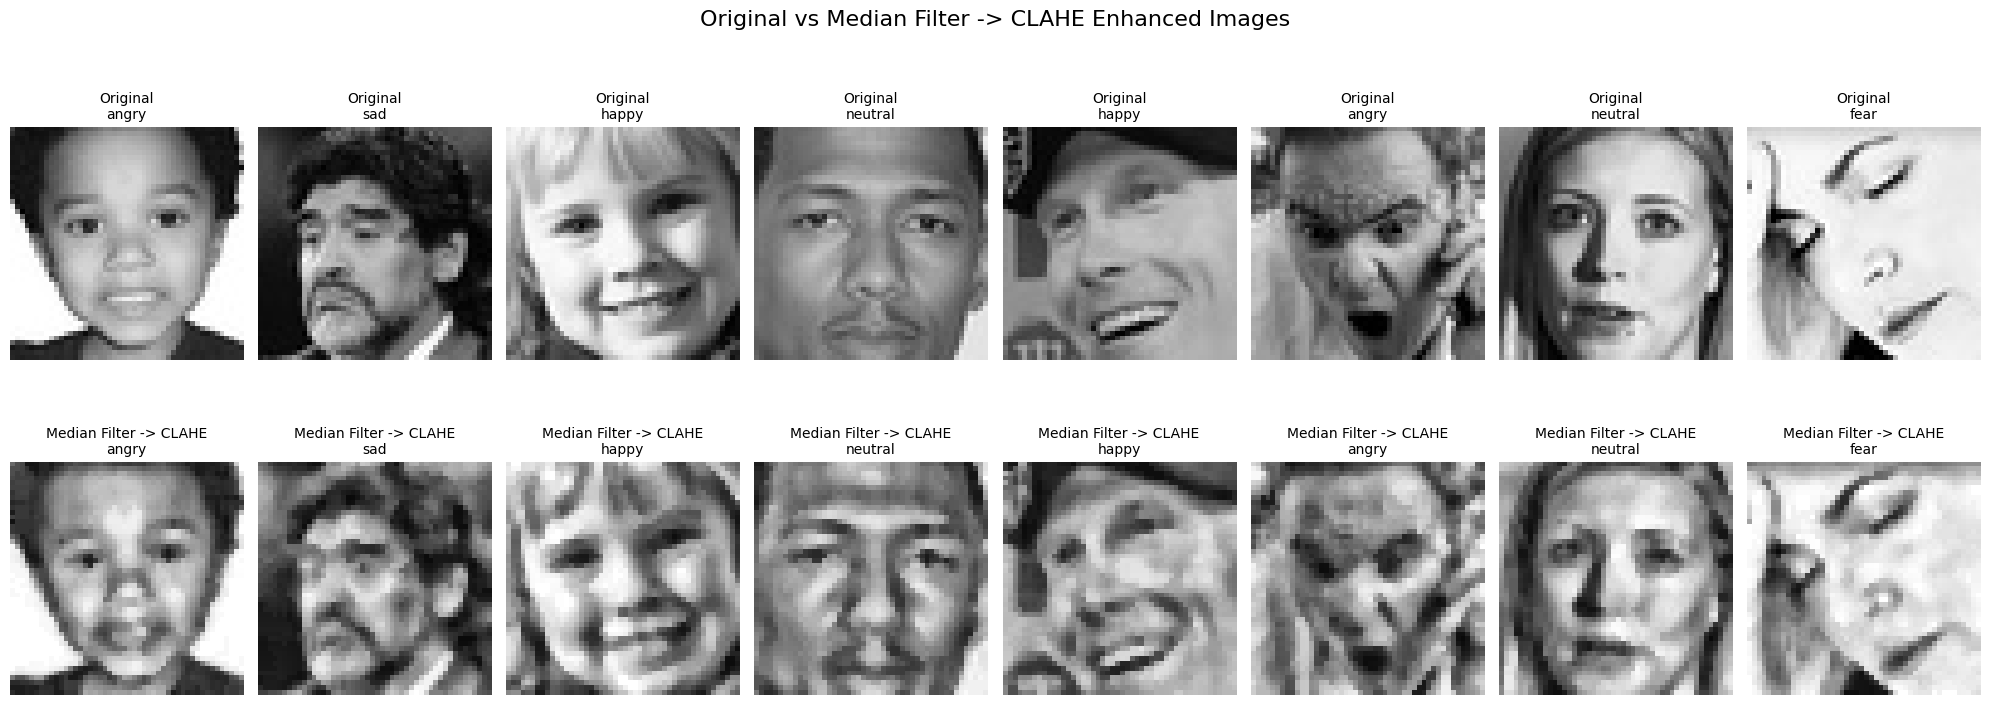

In [11]:
x_median_clahe = apply_clahe(X_median_filtered, clip_limit=2.0, tile_grid_size=(8, 8)) 
plot_transformation_comparison(X, x_median_clahe, "Median Filter -> CLAHE", emotion_labels, y, n_samples=8)

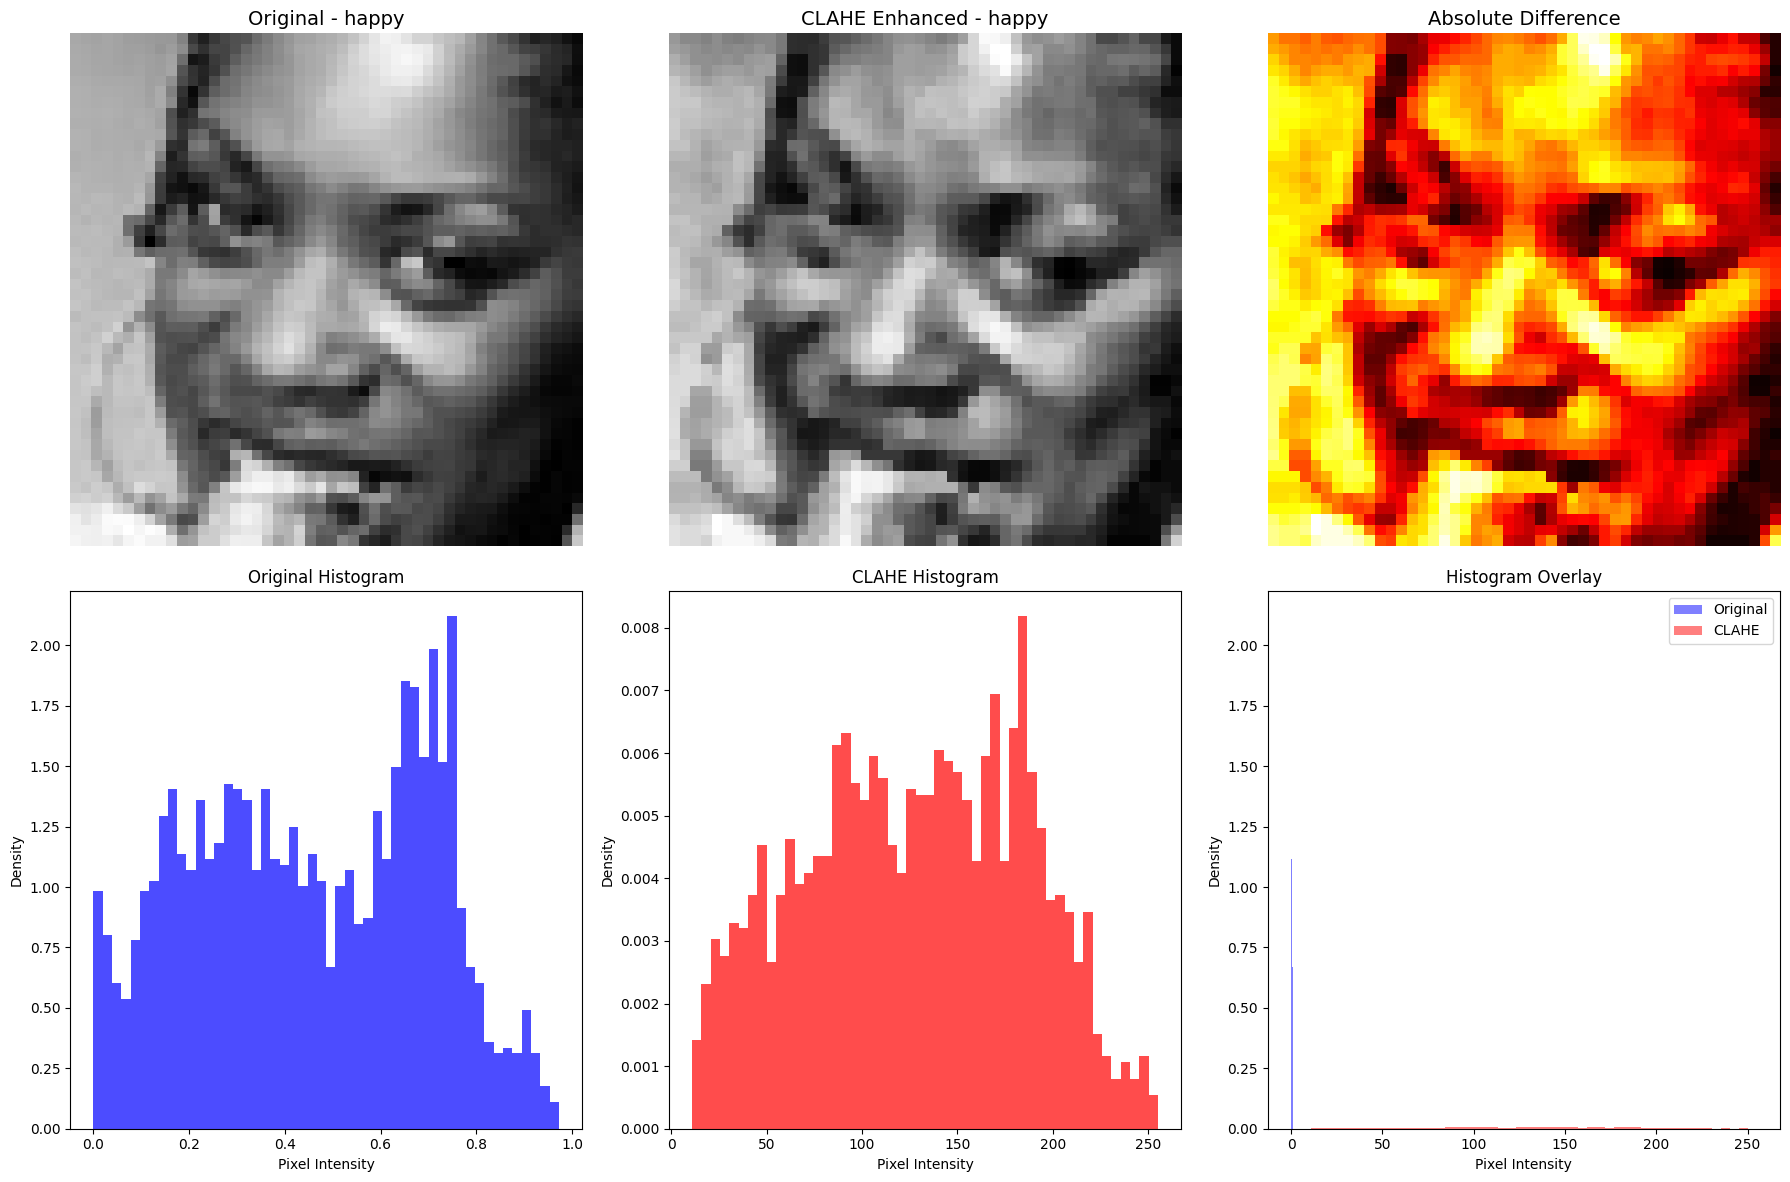

Image Statistics for sample 15055 (happy):
Original  - Mean: 0.45, Std: 0.24
CLAHE     - Mean: 127.22, Std: 57.43
Contrast improvement: 57.19


In [12]:
# Side-by-side detailed comparison with zoom

def detailed_clahe_comparison(X_original, X_clahe, emotion_labels, y, sample_idx=None):
    """
    Detailed side-by-side comparison with zoomed regions
    """
    if sample_idx is None:
        sample_idx = np.random.randint(0, len(X_original))
    
    orig_img = X_original[sample_idx]
    clahe_img = X_clahe[sample_idx]
    emotion = emotion_labels[y[sample_idx]]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Full images
    axes[0, 0].imshow(orig_img, cmap='gray')
    axes[0, 0].set_title(f'Original - {emotion}', fontsize=14)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(clahe_img, cmap='gray')
    axes[0, 1].set_title(f'CLAHE Enhanced - {emotion}', fontsize=14)
    axes[0, 1].axis('off')
    
    # Difference image
    diff_img = np.abs(clahe_img.astype(float) - orig_img.astype(float))
    axes[0, 2].imshow(diff_img, cmap='hot')
    axes[0, 2].set_title('Absolute Difference', fontsize=14)
    axes[0, 2].axis('off')
    
    # Histograms
    axes[1, 0].hist(orig_img.flatten(), bins=50, alpha=0.7, color='blue', density=True)
    axes[1, 0].set_title('Original Histogram')
    axes[1, 0].set_xlabel('Pixel Intensity')
    axes[1, 0].set_ylabel('Density')
    
    axes[1, 1].hist(clahe_img.flatten(), bins=50, alpha=0.7, color='red', density=True)
    axes[1, 1].set_title('CLAHE Histogram')
    axes[1, 1].set_xlabel('Pixel Intensity')
    axes[1, 1].set_ylabel('Density')
    
    # Overlay histograms
    axes[1, 2].hist(orig_img.flatten(), bins=50, alpha=0.5, color='blue', density=True, label='Original')
    axes[1, 2].hist(clahe_img.flatten(), bins=50, alpha=0.5, color='red', density=True, label='CLAHE')
    axes[1, 2].set_title('Histogram Overlay')
    axes[1, 2].set_xlabel('Pixel Intensity')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for this specific image
    print(f"Image Statistics for sample {sample_idx} ({emotion}):")
    print(f"Original  - Mean: {np.mean(orig_img):.2f}, Std: {np.std(orig_img):.2f}")
    print(f"CLAHE     - Mean: {np.mean(clahe_img):.2f}, Std: {np.std(clahe_img):.2f}")
    print(f"Contrast improvement: {np.std(clahe_img) - np.std(orig_img):.2f}")

# Show detailed comparison for a random sample
detailed_clahe_comparison(X, x_median_clahe, emotion_labels=emotion_labels, y=y)

## Resize and normalize 

In [13]:
# Resize to (64, 64) and normalize to [0, 1]
x_resized = np.array([cv2.resize(img, (64, 64)) for img in x_median_clahe])
x_preprocessed = x_resized.astype('float32') / 255.0
x_preprocessed = x_preprocessed.reshape(-1, 64, 64, 1)  # Add channel dimension


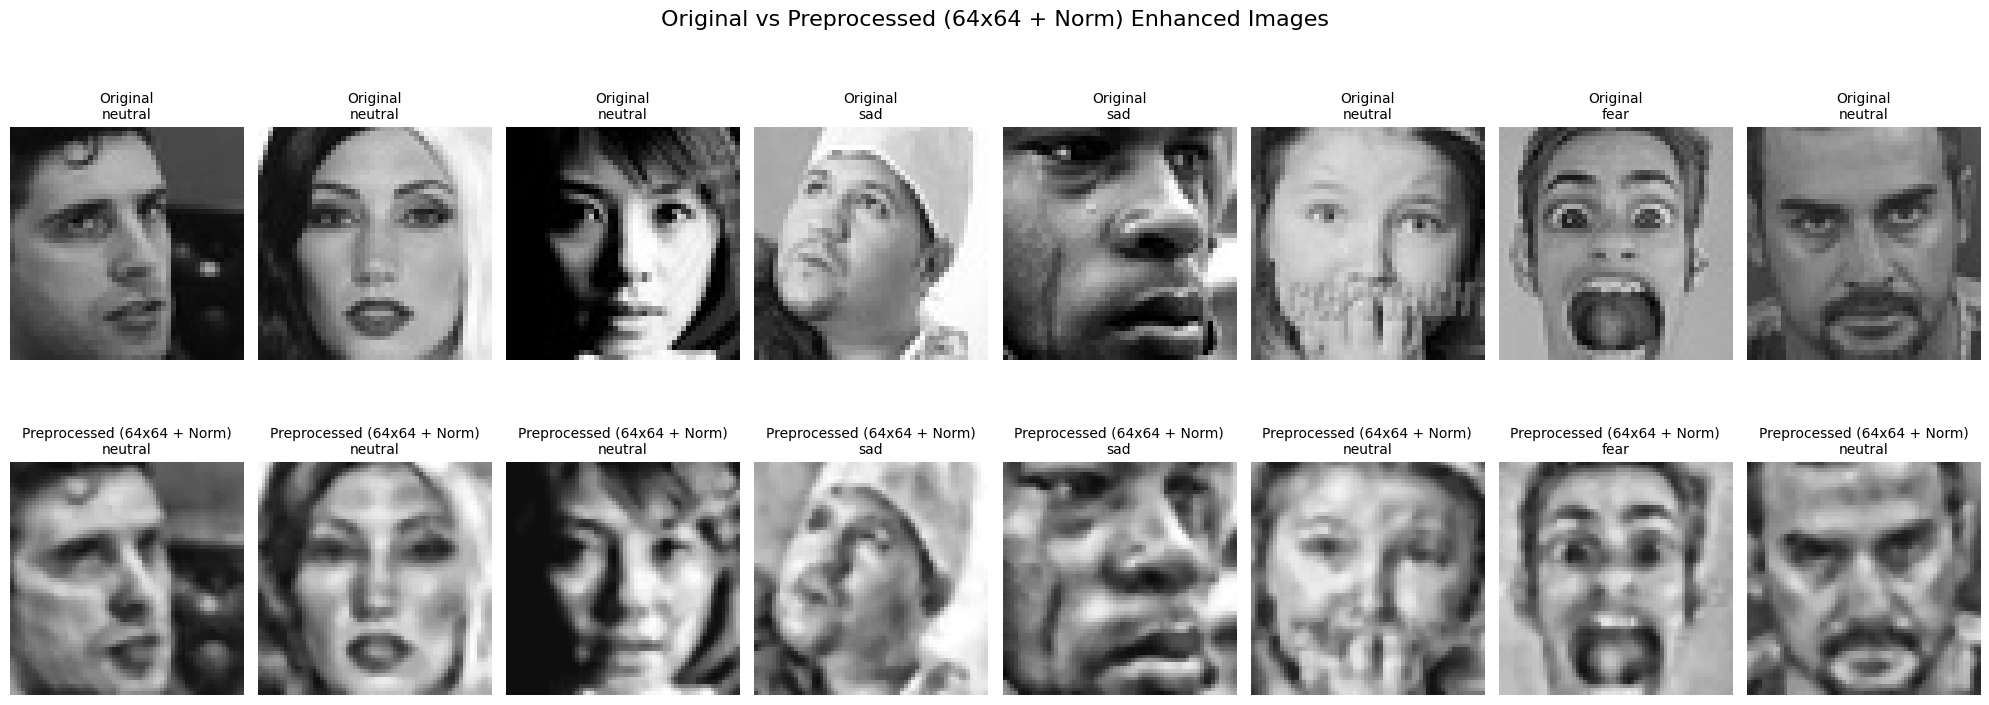

In [14]:
plot_transformation_comparison(X , x_preprocessed, "Preprocessed (64x64 + Norm)", emotion_labels, y, n_samples=8 )

## HOG

In [15]:
from skimage.feature import hog
x_hog = []
for img in tqdm(x_preprocessed):
    hog_features = hog(
        img.squeeze(),
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False    )
    x_hog.append(hog_features)
x_hog = np.array(x_hog)
print(f"HOG feature shape: {x_hog.shape}")


100%|██████████| 28709/28709 [00:40<00:00, 715.86it/s]



HOG feature shape: (28709, 1764)


## LBP

In [16]:
# lbp 
def lbp_grid_hist(img, P=8, R=1, grid=(8,8), method='uniform'):
    H, W = img.shape
    gy, gx = grid
    lbp = local_binary_pattern(img, P=P, R=R, method=method)
    
    n_bins = P + 2
    cell_h, cell_w = H // gy, W // gx

    feats = []
    for i in range(gy):
        for j in range(gx):
            y0, y1 = i*cell_h, (i+1)*cell_h if i<gy-1 else H
            x0, x1 = j*cell_w, (j+1)*cell_w if j<gx-1 else W
            cell = lbp[y0:y1, x0:x1].ravel()
            hist, _ = np.histogram(cell, bins=np.arange(0, n_bins+1), range=(0, n_bins))
            hist = hist.astype(np.float32)
            hist /= (hist.sum() + 1e-8)
            feats.append(hist)
    return np.concatenate(feats, axis=0)  # (gy*gx*n_bins,)

x_lbp = []
for img in tqdm(x_preprocessed):
    lbp_features = lbp_grid_hist(img.squeeze(), P=8, R=1, grid=(8,8), method='uniform')
    x_lbp.append(lbp_features)

x_lbp = np.array(x_lbp)
print(f"LBP feature shape: {x_lbp.shape}")


  0%|          | 0/28709 [00:00<?, ?it/s]d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 28709/28709 [01:09<00:00, 411.89it/s]


LBP feature shape: (28709, 640)


## SIFT

In [17]:

x_sift = []
sift = cv2.SIFT_create()
for img in tqdm(x_preprocessed):
    keypoints, descriptors = sift.detectAndCompute((img.squeeze() * 255).astype('uint8'), None)
    if descriptors is not None:
        sift_feature = descriptors.flatten()
        if sift_feature.shape[0] < 128 * 10:  # Pad to fixed size
            sift_feature = np.pad(sift_feature, (0, 128 * 10 - sift_feature.shape[0]), 'constant')
        else:
            sift_feature = sift_feature[:128 * 10]  # Truncate if too long
    else:
        sift_feature = np.zeros(128 * 10)  
    x_sift.append(sift_feature)

100%|██████████| 28709/28709 [01:06<00:00, 434.38it/s]



## Combine all feature 

In [18]:
X_train = np.concatenate([x_hog, x_lbp, x_sift], axis=1)
print(f"Combined feature shape: {X_train.shape}")

Combined feature shape: (28709, 3684)


## Prepare for Model 

- Standard scaler 
- PCA 

In [19]:
# standard scaler
scaler = StandardScaler()
X_train_scaler  = scaler.fit_transform(X_train)
# PCA 
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaler)
print(f"PCA reduced shape: {X_train_pca.shape}")

PCA reduced shape: (28709, 1614)


## Prepare test data


In [20]:
X_test , y_test , labels = load_fer2013_data('data/test') 


Loading and preprocessing images...
Processing angry: 958 images


Loading angry: 100%|██████████| 958/958 [00:08<00:00, 119.74it/s]


Processing disgust: 111 images


Loading disgust: 100%|██████████| 111/111 [00:00<00:00, 124.08it/s]


Processing fear: 1024 images


Loading fear: 100%|██████████| 1024/1024 [00:08<00:00, 119.90it/s]



Processing happy: 1774 images


Loading happy: 100%|██████████| 1774/1774 [00:14<00:00, 118.50it/s]



Processing sad: 1247 images


Loading sad: 100%|██████████| 1247/1247 [00:10<00:00, 119.66it/s]


Processing surprise: 831 images


Loading surprise: 100%|██████████| 831/831 [00:06<00:00, 126.64it/s]



Processing neutral: 1233 images


Loading neutral: 100%|██████████| 1233/1233 [00:10<00:00, 121.25it/s]



In [21]:
def preprocess_test_data(X_test, scaler, pca, target_size=(64, 64)):
    """
    Preprocess test data using the same pipeline as training data
    
    Parameters:
    - X_test: Raw test images
    - scaler: Fitted StandardScaler from training
    - pca: Fitted PCA from training
    - target_size: Target image size (default: (64, 64))
    
    Returns:
    - X_test_processed: Preprocessed test data ready for model prediction
    - preprocessing_info: Dictionary containing intermediate results for analysis
    """
    
    print("🔄 Processing test data through the same pipeline...")
    print("=" * 60)
    
    # Store intermediate results for analysis
    preprocessing_info = {}
    
    # Step 1: Median Filter
    print("Step 1/8: Applying Median Filter...")
    X_test_median = np.array([cv2.medianBlur(img, 3) for img in tqdm(X_test)])
    preprocessing_info['median_filtered'] = X_test_median
    
    # Step 2: CLAHE Enhancement
    print("Step 2/8: Applying CLAHE Enhancement...")
    X_test_clahe = apply_clahe(X_test_median, clip_limit=2.0, tile_grid_size=(8, 8))
    preprocessing_info['clahe_enhanced'] = X_test_clahe
    
    # Step 3: Resize and Normalize
    print("Step 3/8: Resizing and Normalizing...")
    X_test_resized = np.array([cv2.resize(img, target_size) for img in X_test_clahe])
    X_test_normalized = X_test_resized.astype('float32') / 255.0
    X_test_with_channel = X_test_normalized.reshape(-1, target_size[0], target_size[1], 1)
    preprocessing_info['normalized'] = X_test_with_channel
    
    # Step 4: HOG Feature Extraction
    print("Step 4/8: Extracting HOG Features...")
    X_test_hog = []
    for img in tqdm(X_test_with_channel):
        hog_features = hog(
            img.squeeze(),
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        X_test_hog.append(hog_features)
    
    X_test_hog = np.array(X_test_hog)
    preprocessing_info['hog_features'] = X_test_hog
    print(f"HOG features shape: {X_test_hog.shape}")
    
    # Step 5: LBP Feature Extraction
    print("Step 5/8: Extracting LBP Features...")
    x_test_lbp = []
    for img in tqdm(X_test_with_channel):
        lbp_features = lbp_grid_hist(img.squeeze(), P=8, R=1, grid=(8,8), method='uniform')
        x_test_lbp.append(lbp_features)
    x_test_lbp = np.array(x_test_lbp)
    print(f"LBP features shape: {x_test_lbp.shape}")
    preprocessing_info['lbp_features'] = x_test_lbp
    
    # Step 6: SIFT Feature Extraction
    print("Step 6/8: Extracting SIFT Features...")
    x_test_sift = []
    sift = cv2.SIFT_create()
    for img in tqdm(X_test_with_channel):
        keypoints, descriptors = sift.detectAndCompute((img.squeeze() * 255).astype('uint8'), None)
        if descriptors is not None:
            sift_feature = descriptors.flatten()
            if sift_feature.shape[0] < 128 * 10:  # Pad to fixed size
                sift_feature = np.pad(sift_feature, (0, 128 * 10 - sift_feature.shape[0]), 'constant')
            else:
                sift_feature = sift_feature[:128 * 10]  # Truncate if too long
        else:
            sift_feature = np.zeros(128 * 10)  # No keypoints found
        x_test_sift.append(sift_feature)
    
    x_test_sift = np.array(x_test_sift)
    print(f"SIFT features shape: {x_test_sift.shape}")
    preprocessing_info['sift_features'] = x_test_sift
    
    # Step 7: Combine all features (HOG + LBP + SIFT)
    print("Step 7/8: Combining all features...")
    X_test_combined = np.concatenate([X_test_hog, x_test_lbp, x_test_sift], axis=1)
    print(f"Combined features shape: {X_test_combined.shape}")
    preprocessing_info['combined'] = X_test_combined
    
    # Step 8: Standard Scaling (using fitted scaler)
    print("Step 8/8: Applying Standard Scaling and PCA...")
    X_test_scaled = scaler.transform(X_test_combined)  # Use transform, not fit_transform
    preprocessing_info['scaled'] = X_test_scaled
    
    # PCA (using fitted PCA)
    X_test_pca = pca.transform(X_test_scaled)  # Use transform, not fit_transform
    preprocessing_info['pca'] = X_test_pca
    
    print(f"✅ Test data preprocessing completed!")
    print(f"Final processed shape: {X_test_pca.shape}")
    print(f"Original test set size: {len(X_test)}")
    print("=" * 60)
    
    return X_test_pca, preprocessing_info


print("📊 Processing test data...")
X_test_processed, test_preprocessing_info = preprocess_test_data(
    X_test, 
    scaler=scaler,  # Use the fitted scaler from training
    pca=pca,        # Use the fitted PCA from training
    target_size=(64, 64)
)


📊 Processing test data...
🔄 Processing test data through the same pipeline...
Step 1/8: Applying Median Filter...


100%|██████████| 7178/7178 [00:00<00:00, 113416.79it/s]



Step 2/8: Applying CLAHE Enhancement...
Applying CLAHE to images...


100%|██████████| 7178/7178 [00:00<00:00, 16335.60it/s]



Step 3/8: Resizing and Normalizing...
Step 4/8: Extracting HOG Features...


100%|██████████| 7178/7178 [00:09<00:00, 782.09it/s]


HOG features shape: (7178, 1764)
Step 5/8: Extracting LBP Features...


  0%|          | 0/7178 [00:00<?, ?it/s]d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  0%|          | 35/7178 [00:00<00:20, 349.54it/s]d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 7178/7178 [00:16<00:00, 438.08it/s]


LBP features shape: (7178, 640)
Step 6/8: Extracting SIFT Features...


100%|██████████| 7178/7178 [00:18<00:00, 396.97it/s]



SIFT features shape: (7178, 1280)
Step 7/8: Combining all features...
Combined features shape: (7178, 3684)
Step 8/8: Applying Standard Scaling and PCA...
✅ Test data preprocessing completed!
Final processed shape: (7178, 1614)
Original test set size: 7178
✅ Test data preprocessing completed!
Final processed shape: (7178, 1614)
Original test set size: 7178


In [22]:



models = {
    "SVM (RBF)": SVC(
        kernel='rbf',
        C=10,
        gamma=0.01,
        class_weight='balanced',
        probability=True,
        random_state=42
    ),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    
    "Logistic Regression": LogisticRegression(
        solver='lbfgs',
        max_iter=2000,
        C=1.0,
        multi_class='auto',
        class_weight='balanced',
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_lambda=1.0,
        objective='multi:softmax',
        num_class=len(np.unique(y)),
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
}



In [23]:

results = []

for name, model in tqdm(models.items()):
    print(f"\n🔹 Training {name} with HOG + LBP + SIFT features...")
    model.fit(X_train_pca, y)  # Use X_train_pca (combined HOG + LBP + SIFT)
    
    y_pred = model.predict(X_test_processed)
    acc = accuracy_score(y_test, y_pred)
    print(f"🎯 {name} Accuracy: {acc*100:.2f}%")
    
    results.append((name, acc))
    print(classification_report(y_test, y_pred, target_names=emotion_labels))

# Print results summary
print("\n" + "="*60)
print("TRAINING COMPLETED - Results Summary:")
print("="*60)
for model_name, accuracy in results:
    print(f"{model_name:25s}: {accuracy*100:.2f}%")


  0%|          | 0/4 [00:00<?, ?it/s]


🔹 Training SVM (RBF) with HOG + LBP + SIFT features...


 25%|██▌       | 1/4 [5:58:40<17:56:02, 21520.80s/it]

🎯 SVM (RBF) Accuracy: 31.50%
              precision    recall  f1-score   support

       angry       0.94      0.07      0.12       958
     disgust       1.00      0.27      0.43       111
        fear       0.90      0.09      0.16      1024
       happy       0.27      1.00      0.42      1774
         sad       0.95      0.03      0.06      1247
    surprise       0.98      0.27      0.43       831
     neutral       0.93      0.03      0.07      1233

    accuracy                           0.31      7178
   macro avg       0.85      0.25      0.24      7178
weighted avg       0.77      0.31      0.22      7178


🔹 Training Random Forest with HOG + LBP + SIFT features...


 50%|█████     | 2/4 [5:59:48<4:56:42, 8901.31s/it]  

🎯 Random Forest Accuracy: 34.23%
              precision    recall  f1-score   support

       angry       0.83      0.07      0.13       958
     disgust       1.00      0.27      0.43       111
        fear       0.78      0.10      0.17      1024
       happy       0.29      0.97      0.45      1774
         sad       0.37      0.07      0.12      1247
    surprise       0.98      0.28      0.43       831
     neutral       0.40      0.17      0.24      1233

    accuracy                           0.34      7178
   macro avg       0.66      0.28      0.28      7178
weighted avg       0.56      0.34      0.27      7178


🔹 Training Logistic Regression with HOG + LBP + SIFT features...


d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
 75%|███████▌  | 3/4 [6:01:01<1:21:10, 4870.06s/it]

🎯 Logistic Regression Accuracy: 40.68%
              precision    recall  f1-score   support

       angry       0.29      0.32      0.31       958
     disgust       0.19      0.41      0.26       111
        fear       0.28      0.27      0.28      1024
       happy       0.63      0.57      0.60      1774
         sad       0.31      0.27      0.29      1247
    surprise       0.46      0.58      0.52       831
     neutral       0.40      0.37      0.38      1233

    accuracy                           0.41      7178
   macro avg       0.37      0.40      0.38      7178
weighted avg       0.41      0.41      0.41      7178


🔹 Training XGBoost with HOG + LBP + SIFT features...


100%|██████████| 4/4 [6:12:59<00:00, 5594.99s/it]  

🎯 XGBoost Accuracy: 44.57%
              precision    recall  f1-score   support

       angry       0.38      0.23      0.29       958
     disgust       1.00      0.27      0.43       111
        fear       0.39      0.22      0.28      1024
       happy       0.47      0.79      0.59      1774
         sad       0.33      0.30      0.32      1247
    surprise       0.75      0.48      0.59       831
     neutral       0.40      0.43      0.41      1233

    accuracy                           0.45      7178
   macro avg       0.53      0.39      0.42      7178
weighted avg       0.45      0.45      0.43      7178


TRAINING COMPLETED - Results Summary:
SVM (RBF)                : 31.50%
Random Forest            : 34.23%
Logistic Regression      : 40.68%
XGBoost                  : 44.57%


In [24]:
## Model Evaluation & Visualization

In [25]:
# Organize results into structured format for evaluation
model_results = {}

for (model_name, accuracy), model in zip(results, models.values()):
    y_pred = model.predict(X_test_processed)
    
    model_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'classification_report': classification_report(y_test, y_pred, target_names=emotion_labels, output_dict=True)
    }

print("✅ Model results organized for detailed evaluation")


✅ Model results organized for detailed evaluation


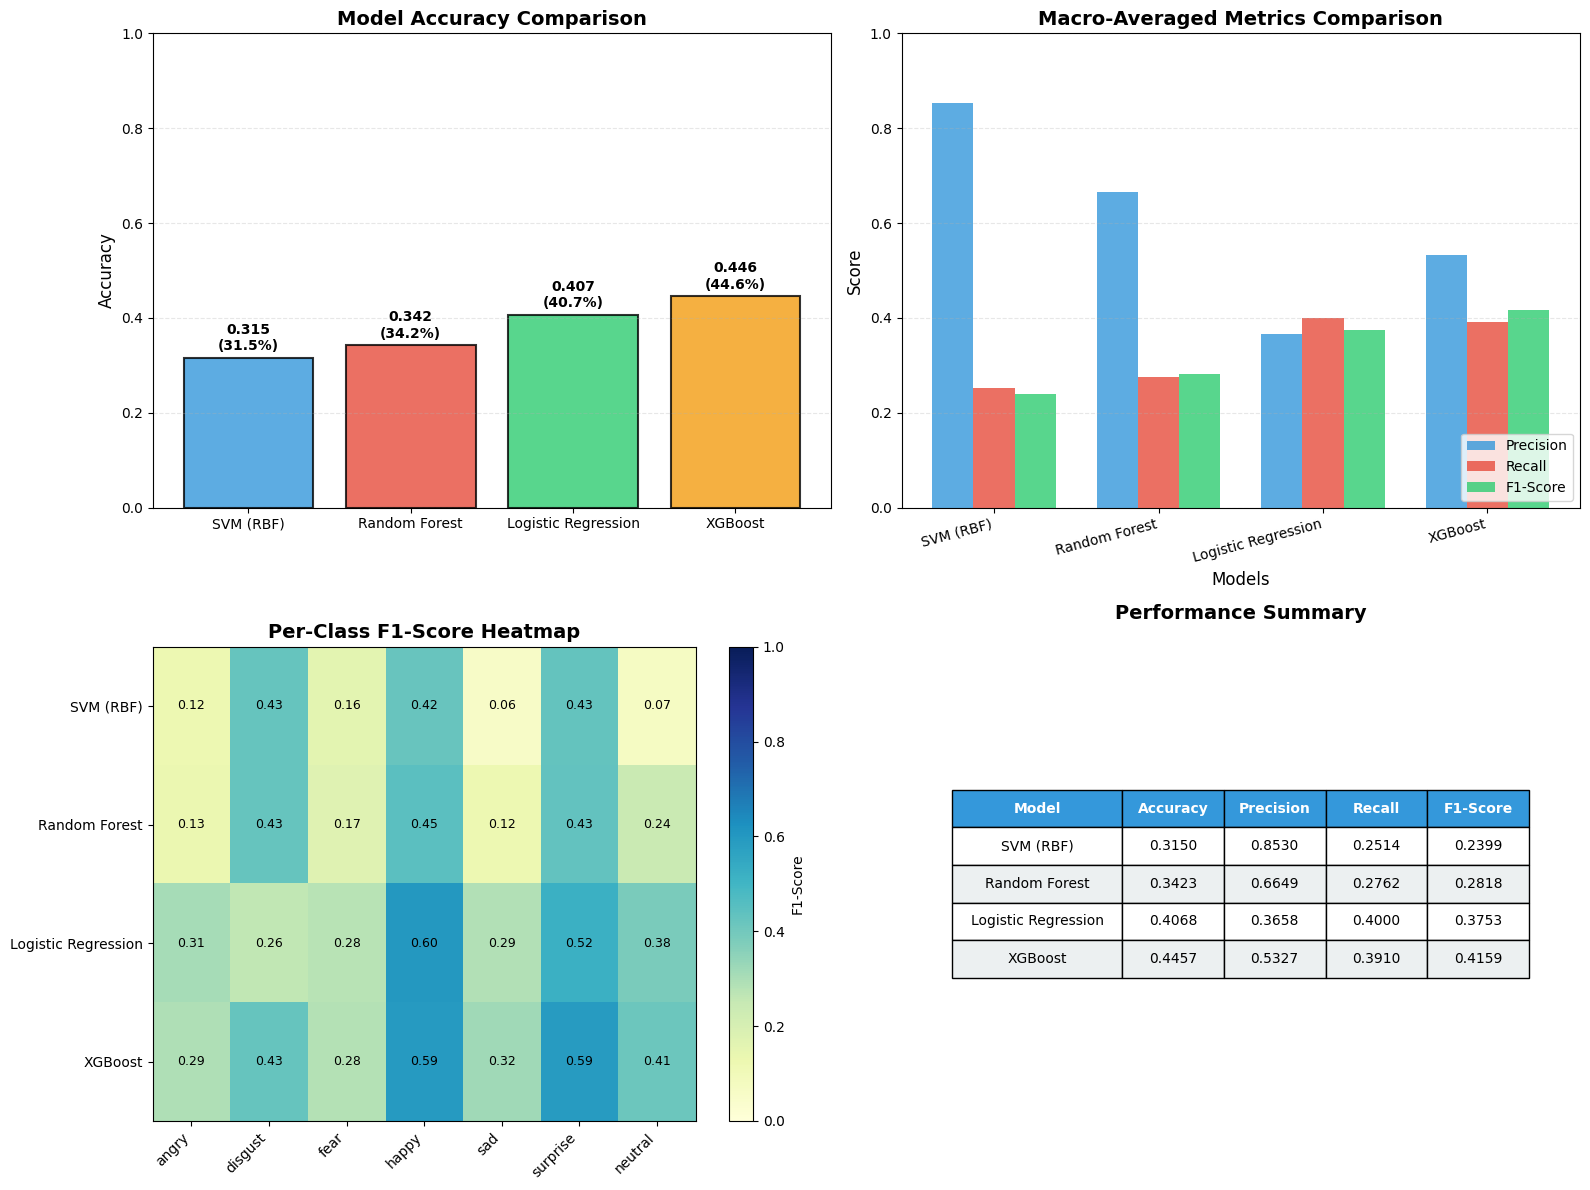

In [26]:
# 1. Model Accuracy Comparison Bar Chart
def plot_model_comparison(model_results):
    """
    Plot comprehensive model comparison
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    model_names = list(model_results.keys())
    accuracies = [model_results[name]['accuracy'] for name in model_names]
    
    # 1. Accuracy Bar Chart
    ax1 = axes[0, 0]
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    bars = ax1.bar(model_names, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}\n({acc*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Macro-averaged Metrics (Precision, Recall, F1)
    ax2 = axes[0, 1]
    metrics_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        metrics_data.append([
            report['macro avg']['precision'],
            report['macro avg']['recall'],
            report['macro avg']['f1-score']
        ])
    
    metrics_data = np.array(metrics_data)
    x = np.arange(len(model_names))
    width = 0.25
    
    ax2.bar(x - width, metrics_data[:, 0], width, label='Precision', alpha=0.8, color='#3498db')
    ax2.bar(x, metrics_data[:, 1], width, label='Recall', alpha=0.8, color='#e74c3c')
    ax2.bar(x + width, metrics_data[:, 2], width, label='F1-Score', alpha=0.8, color='#2ecc71')
    
    ax2.set_xlabel('Models', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Macro-Averaged Metrics Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names, rotation=15, ha='right')
    ax2.legend(loc='lower right')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # 3. Per-Class F1-Score Heatmap
    ax3 = axes[1, 0]
    f1_scores = []
    for name in model_names:
        report = model_results[name]['classification_report']
        class_f1 = [report[emotion]['f1-score'] for emotion in emotion_labels]
        f1_scores.append(class_f1)
    
    f1_scores = np.array(f1_scores)
    im = ax3.imshow(f1_scores, cmap='YlGnBu', aspect='auto', vmin=0, vmax=1)
    ax3.set_xticks(np.arange(len(emotion_labels)))
    ax3.set_yticks(np.arange(len(model_names)))
    ax3.set_xticklabels(emotion_labels, rotation=45, ha='right')
    ax3.set_yticklabels(model_names)
    ax3.set_title('Per-Class F1-Score Heatmap', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(model_names)):
        for j in range(len(emotion_labels)):
            text = ax3.text(j, i, f'{f1_scores[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax3, label='F1-Score')
    
    # 4. Model Performance Summary Table
    ax4 = axes[1, 1]
    ax4.axis('tight')
    ax4.axis('off')
    
    summary_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        summary_data.append([
            name,
            f"{model_results[name]['accuracy']:.4f}",
            f"{report['macro avg']['precision']:.4f}",
            f"{report['macro avg']['recall']:.4f}",
            f"{report['macro avg']['f1-score']:.4f}"
        ])
    
    table = ax4.table(cellText=summary_data,
                     colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.25, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Style rows
    for i in range(1, len(summary_data) + 1):
        for j in range(5):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')
    
    ax4.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_model_comparison(model_results)


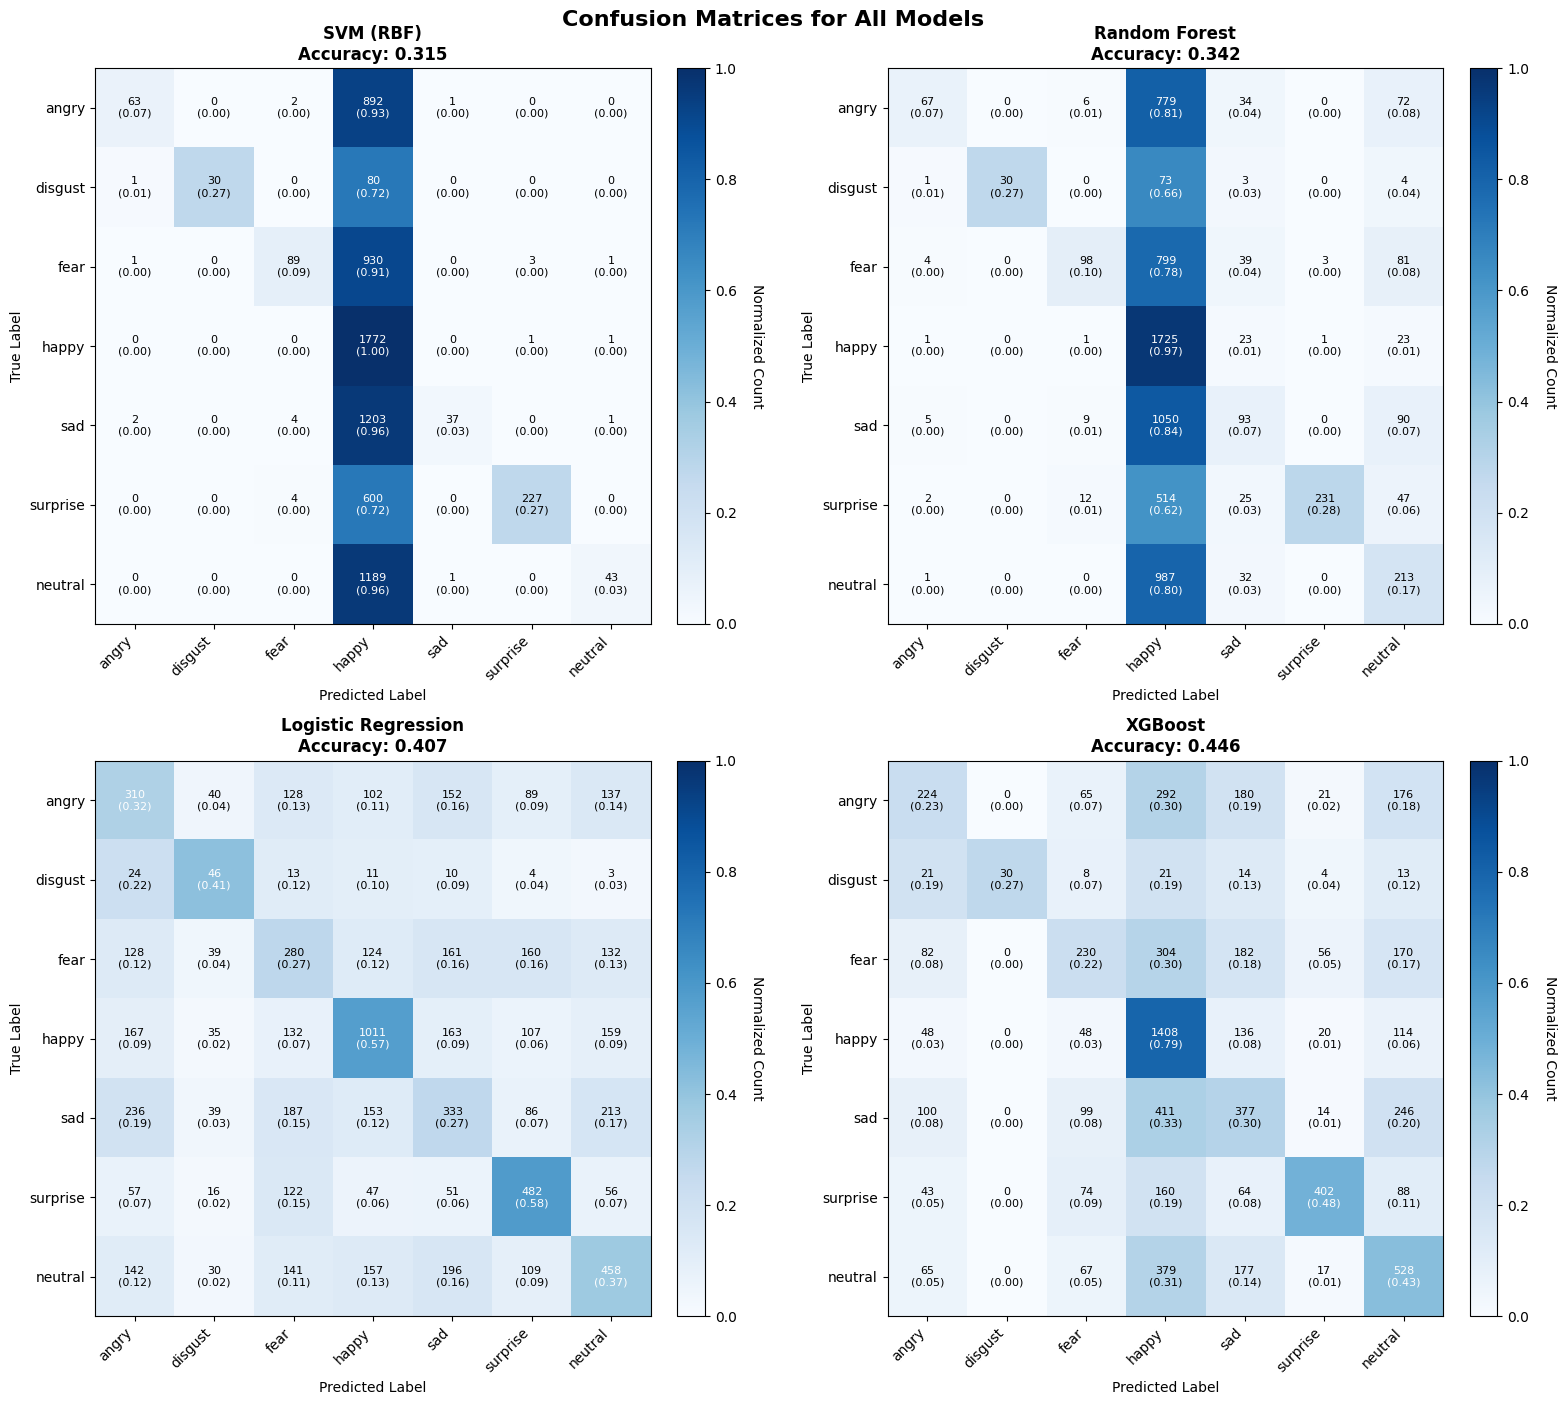

In [27]:
# 2. Confusion Matrices for All Models
def plot_confusion_matrices(model_results, emotion_labels):
    """
    Plot confusion matrices for all models in a grid
    """
    n_models = len(model_results)
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    for idx, (model_name, result) in enumerate(model_results.items()):
        cm = confusion_matrix(y_test, result['predictions'])
        
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        ax = axes[idx]
        im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f'{model_name}\nAccuracy: {result["accuracy"]:.3f}', 
                    fontsize=12, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Normalized Count', rotation=270, labelpad=20)
        
        # Set ticks
        tick_marks = np.arange(len(emotion_labels))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels(emotion_labels, rotation=45, ha='right')
        ax.set_yticklabels(emotion_labels)
        
        # Add text annotations
        thresh = cm_normalized.max() / 2.
        for i in range(cm_normalized.shape[0]):
            for j in range(cm_normalized.shape[1]):
                ax.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                       ha="center", va="center",
                       color="white" if cm_normalized[i, j] > thresh else "black",
                       fontsize=8)
        
        ax.set_ylabel('True Label', fontsize=10)
        ax.set_xlabel('Predicted Label', fontsize=10)
        ax.grid(False)
    
    plt.tight_layout()
    plt.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold', y=1.00)
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(model_results, emotion_labels)


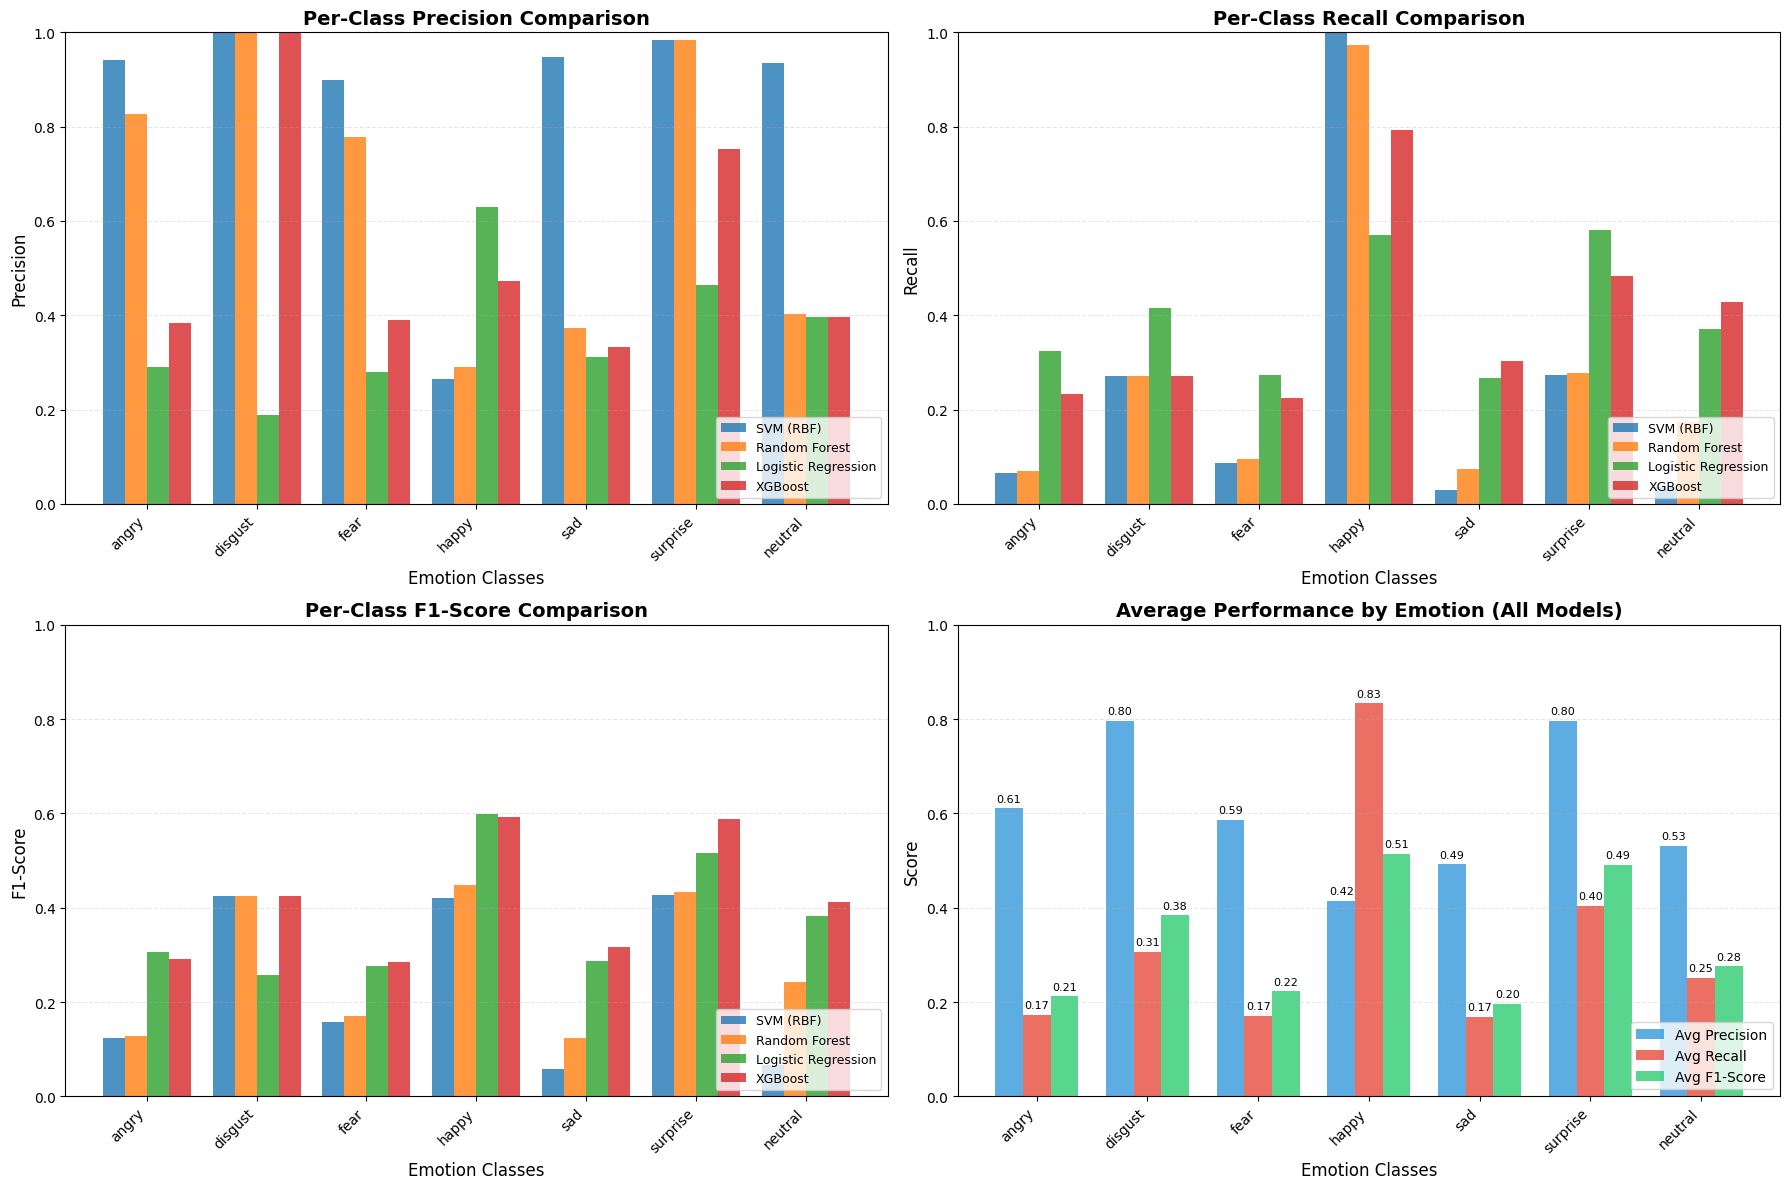

In [28]:
# 3. Per-Class Performance Analysis
def plot_per_class_analysis(model_results, emotion_labels):
    """
    Detailed per-class performance analysis across all models
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Prepare data
    model_names = list(model_results.keys())
    
    # 1. Per-Class Precision
    ax1 = axes[0, 0]
    precision_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        class_precision = [report[emotion]['precision'] for emotion in emotion_labels]
        precision_data.append(class_precision)
    
    x = np.arange(len(emotion_labels))
    width = 0.2
    for i, (name, data) in enumerate(zip(model_names, precision_data)):
        ax1.bar(x + i * width, data, width, label=name, alpha=0.8)
    
    ax1.set_xlabel('Emotion Classes', fontsize=12)
    ax1.set_ylabel('Precision', fontsize=12)
    ax1.set_title('Per-Class Precision Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels(emotion_labels, rotation=45, ha='right')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim(0, 1)
    
    # 2. Per-Class Recall
    ax2 = axes[0, 1]
    recall_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        class_recall = [report[emotion]['recall'] for emotion in emotion_labels]
        recall_data.append(class_recall)
    
    for i, (name, data) in enumerate(zip(model_names, recall_data)):
        ax2.bar(x + i * width, data, width, label=name, alpha=0.8)
    
    ax2.set_xlabel('Emotion Classes', fontsize=12)
    ax2.set_ylabel('Recall', fontsize=12)
    ax2.set_title('Per-Class Recall Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels(emotion_labels, rotation=45, ha='right')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_ylim(0, 1)
    
    # 3. Per-Class F1-Score
    ax3 = axes[1, 0]
    f1_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        class_f1 = [report[emotion]['f1-score'] for emotion in emotion_labels]
        f1_data.append(class_f1)
    
    for i, (name, data) in enumerate(zip(model_names, f1_data)):
        ax3.bar(x + i * width, data, width, label=name, alpha=0.8)
    
    ax3.set_xlabel('Emotion Classes', fontsize=12)
    ax3.set_ylabel('F1-Score', fontsize=12)
    ax3.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width * 1.5)
    ax3.set_xticklabels(emotion_labels, rotation=45, ha='right')
    ax3.legend(loc='lower right', fontsize=9)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.set_ylim(0, 1)
    
    # 4. Average Performance by Emotion (across all models)
    ax4 = axes[1, 1]
    avg_precision = np.mean(precision_data, axis=0)
    avg_recall = np.mean(recall_data, axis=0)
    avg_f1 = np.mean(f1_data, axis=0)
    
    x_pos = np.arange(len(emotion_labels))
    width = 0.25
    
    ax4.bar(x_pos - width, avg_precision, width, label='Avg Precision', alpha=0.8, color='#3498db')
    ax4.bar(x_pos, avg_recall, width, label='Avg Recall', alpha=0.8, color='#e74c3c')
    ax4.bar(x_pos + width, avg_f1, width, label='Avg F1-Score', alpha=0.8, color='#2ecc71')
    
    ax4.set_xlabel('Emotion Classes', fontsize=12)
    ax4.set_ylabel('Score', fontsize=12)
    ax4.set_title('Average Performance by Emotion (All Models)', fontsize=14, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(emotion_labels, rotation=45, ha='right')
    ax4.legend(loc='lower right')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.set_ylim(0, 1)
    
    # Add value labels on bars
    for i, (p, r, f) in enumerate(zip(avg_precision, avg_recall, avg_f1)):
        ax4.text(i - width, p + 0.01, f'{p:.2f}', ha='center', va='bottom', fontsize=8)
        ax4.text(i, r + 0.01, f'{r:.2f}', ha='center', va='bottom', fontsize=8)
        ax4.text(i + width, f + 0.01, f'{f:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Plot per-class analysis
plot_per_class_analysis(model_results, emotion_labels)


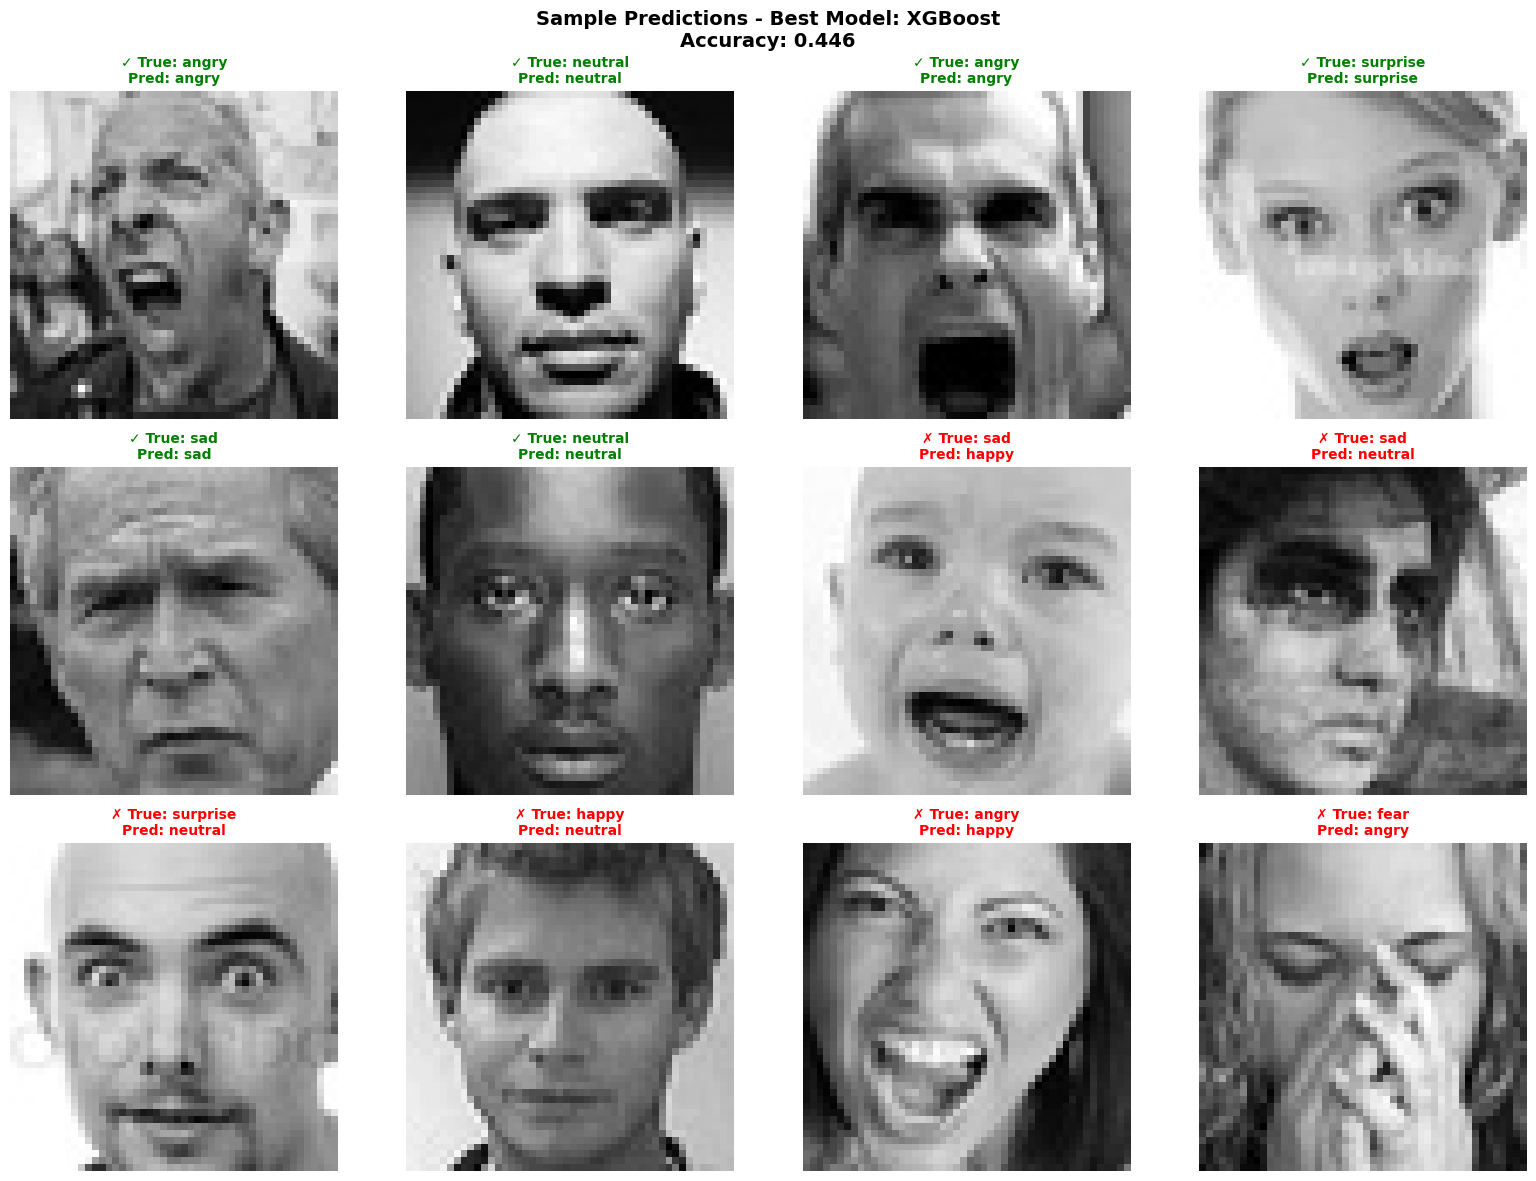

In [29]:
# 4. Sample Predictions Visualization (Best Model)
def visualize_predictions(model_results, X_test, y_test, emotion_labels, n_samples=12):
    """
    Visualize sample predictions from the best model
    """
    # Find best model
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
    best_predictions = model_results[best_model_name]['predictions']
    
    # Select samples: correct and incorrect predictions
    correct_indices = np.where(best_predictions == y_test)[0]
    incorrect_indices = np.where(best_predictions != y_test)[0]
    
    # Sample half correct, half incorrect
    n_correct = n_samples // 2
    n_incorrect = n_samples - n_correct
    
    if len(correct_indices) >= n_correct and len(incorrect_indices) >= n_incorrect:
        selected_correct = np.random.choice(correct_indices, n_correct, replace=False)
        selected_incorrect = np.random.choice(incorrect_indices, n_incorrect, replace=False)
        selected_indices = np.concatenate([selected_correct, selected_incorrect])
    else:
        selected_indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    # Plot
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, test_idx in enumerate(selected_indices):
        ax = axes[idx]
        
        # Get image
        img = X_test[test_idx]
        
        # Handle different image formats
        if img.max() <= 1.0:
            display_img = img
        else:
            display_img = img / 255.0
        
        # Display image
        ax.imshow(display_img, cmap='gray')
        
        # Get prediction and true label
        true_label = emotion_labels[y_test[test_idx]]
        pred_label = emotion_labels[best_predictions[test_idx]]
        
        # Color: green for correct, red for incorrect
        is_correct = (y_test[test_idx] == best_predictions[test_idx])
        color = 'green' if is_correct else 'red'
        marker = '✓' if is_correct else '✗'
        
        ax.set_title(f'{marker} True: {true_label}\nPred: {pred_label}',
                    fontsize=10, color=color, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle(f'Sample Predictions - Best Model: {best_model_name}\n'
                f'Accuracy: {model_results[best_model_name]["accuracy"]:.3f}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model_results, X_test, y_test, emotion_labels, n_samples=12)


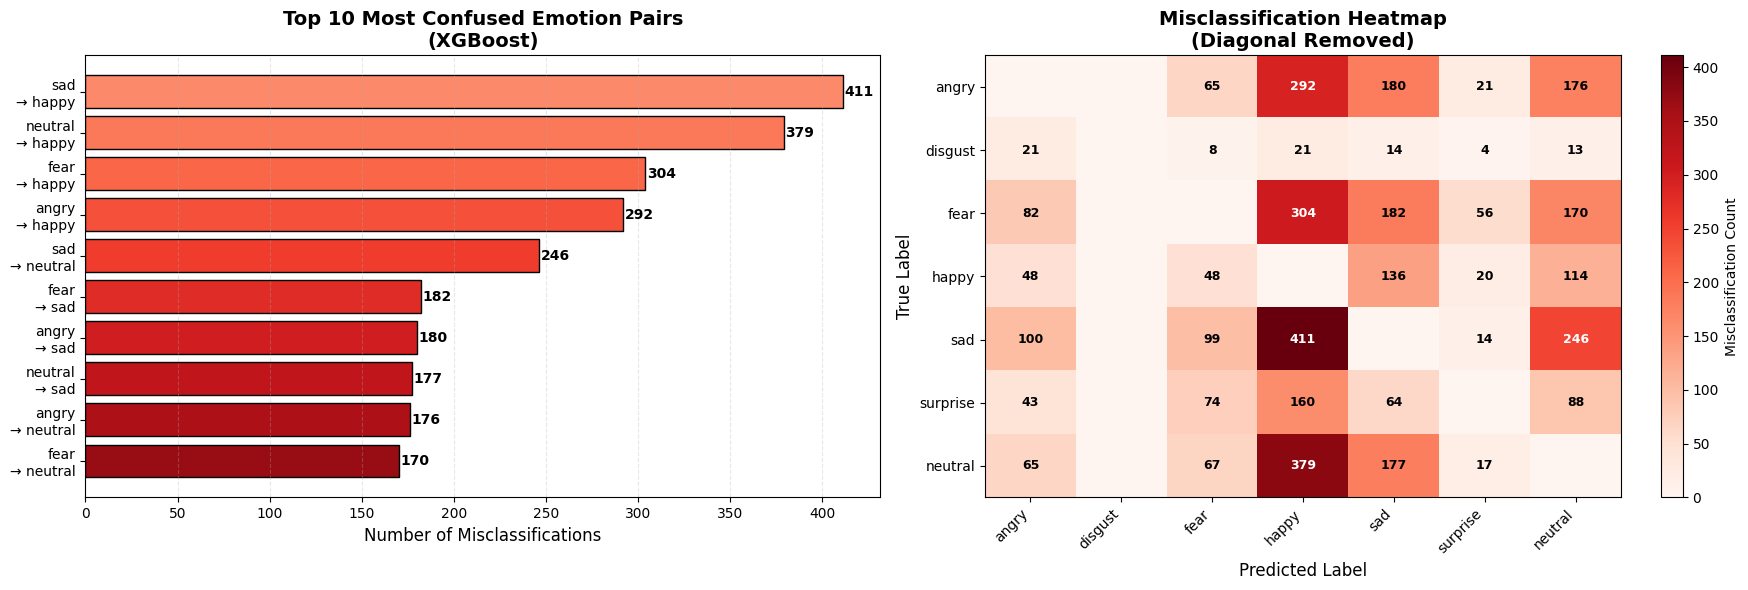

ERROR ANALYSIS SUMMARY - XGBoost

Top 5 Most Confused Pairs:
1. sad → happy: 411 times (5.73% of all predictions)
2. neutral → happy: 379 times (5.28% of all predictions)
3. fear → happy: 304 times (4.24% of all predictions)
4. angry → happy: 292 times (4.07% of all predictions)
5. sad → neutral: 246 times (3.43% of all predictions)

Total Misclassifications: 3979 out of 7178 (55.43%)


In [30]:
# 5. Error Analysis - Most Confused Pairs
def plot_error_analysis(model_results, emotion_labels):
    """
    Analyze and visualize the most confused emotion pairs
    """
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
    best_predictions = model_results[best_model_name]['predictions']
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, best_predictions)
    
    # Find most confused pairs (excluding diagonal)
    confused_pairs = []
    for i in range(len(emotion_labels)):
        for j in range(len(emotion_labels)):
            if i != j:
                confused_pairs.append((emotion_labels[i], emotion_labels[j], cm[i, j]))
    
    # Sort by confusion count
    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    top_confusions = confused_pairs[:10]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # 1. Top 10 Confused Pairs
    pair_labels = [f"{pair[0]}\n→ {pair[1]}" for pair in top_confusions]
    counts = [pair[2] for pair in top_confusions]
    
    colors_gradient = plt.cm.Reds(np.linspace(0.4, 0.9, len(counts)))
    bars = ax1.barh(range(len(pair_labels)), counts, color=colors_gradient, edgecolor='black')
    ax1.set_yticks(range(len(pair_labels)))
    ax1.set_yticklabels(pair_labels, fontsize=10)
    ax1.set_xlabel('Number of Misclassifications', fontsize=12)
    ax1.set_title(f'Top 10 Most Confused Emotion Pairs\n({best_model_name})', 
                 fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        ax1.text(count + 1, i, str(int(count)), 
                va='center', fontsize=10, fontweight='bold')
    
    # 2. Confusion Distribution Heatmap (off-diagonal only)
    cm_off_diag = cm.copy()
    np.fill_diagonal(cm_off_diag, 0)
    
    im = ax2.imshow(cm_off_diag, cmap='Reds', aspect='auto')
    ax2.set_xticks(np.arange(len(emotion_labels)))
    ax2.set_yticks(np.arange(len(emotion_labels)))
    ax2.set_xticklabels(emotion_labels, rotation=45, ha='right')
    ax2.set_yticklabels(emotion_labels)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_title('Misclassification Heatmap\n(Diagonal Removed)', 
                 fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(emotion_labels)):
        for j in range(len(emotion_labels)):
            if i != j and cm_off_diag[i, j] > 0:
                ax2.text(j, i, int(cm_off_diag[i, j]),
                       ha="center", va="center", 
                       color="white" if cm_off_diag[i, j] > cm_off_diag.max()/2 else "black",
                       fontsize=9, fontweight='bold')
    
    plt.colorbar(im, ax=ax2, label='Misclassification Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print error analysis summary
    print("="*60)
    print(f"ERROR ANALYSIS SUMMARY - {best_model_name}")
    print("="*60)
    print("\nTop 5 Most Confused Pairs:")
    for i, (true_label, pred_label, count) in enumerate(top_confusions[:5], 1):
        percentage = (count / cm.sum()) * 100
        print(f"{i}. {true_label} → {pred_label}: {int(count)} times ({percentage:.2f}% of all predictions)")
    
    total_errors = cm.sum() - np.trace(cm)
    print(f"\nTotal Misclassifications: {int(total_errors)} out of {int(cm.sum())} "
          f"({(total_errors/cm.sum())*100:.2f}%)")

# Plot error analysis
plot_error_analysis(model_results, emotion_labels)


In [31]:
# 6. Final Summary Report
def print_final_summary(model_results):
    """
    Print comprehensive final summary report
    """
    print("\n" + "="*80)
    print(" " * 25 + "FINAL EVALUATION REPORT")
    print("="*80)
    
    # Best model
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
    best_accuracy = model_results[best_model_name]['accuracy']
    best_report = model_results[best_model_name]['classification_report']
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
    print(f"   Macro Precision: {best_report['macro avg']['precision']:.4f}")
    print(f"   Macro Recall: {best_report['macro avg']['recall']:.4f}")
    print(f"   Macro F1-Score: {best_report['macro avg']['f1-score']:.4f}")
    
    print("\n" + "-"*80)
    print("DETAILED MODEL COMPARISON:")
    print("-"*80)
    
    # Sort models by accuracy
    sorted_models = sorted(model_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    for rank, (model_name, result) in enumerate(sorted_models, 1):
        report = result['classification_report']
        print(f"\n{rank}. {model_name}")
        print(f"   Accuracy:  {result['accuracy']:.4f}")
        print(f"   Precision: {report['macro avg']['precision']:.4f}")
        print(f"   Recall:    {report['macro avg']['recall']:.4f}")
        print(f"   F1-Score:  {report['macro avg']['f1-score']:.4f}")
    
    print("\n" + "-"*80)
    print("PER-EMOTION PERFORMANCE (Best Model):")
    print("-"*80)
    
    for emotion in emotion_labels:
        metrics = best_report[emotion]
        print(f"\n{emotion.upper():12s} | "
              f"Precision: {metrics['precision']:.3f} | "
              f"Recall: {metrics['recall']:.3f} | "
              f"F1: {metrics['f1-score']:.3f} | "
              f"Support: {int(metrics['support'])}")
    
    print("\n" + "="*80)
    print("FEATURE EXTRACTION PIPELINE:")
    print("="*80)
    print("  1. Preprocessing: Median Filter → CLAHE → Resize (64×64) → Normalize")
    print("  2. Feature Extraction:")
    print("     - HOG (Histogram of Oriented Gradients)")
    print("     - LBP (Local Binary Patterns)")
    print("     - SIFT (Scale-Invariant Feature Transform)")
    print("  3. Dimensionality Reduction: StandardScaler → PCA (95% variance)")
    print("="*80)
    
    return best_model_name, best_accuracy

# Print final summary
best_model, best_acc = print_final_summary(model_results)



                         FINAL EVALUATION REPORT

🏆 BEST MODEL: XGBoost
   Accuracy: 0.4457 (44.57%)
   Macro Precision: 0.5327
   Macro Recall: 0.3910
   Macro F1-Score: 0.4159

--------------------------------------------------------------------------------
DETAILED MODEL COMPARISON:
--------------------------------------------------------------------------------

1. XGBoost
   Accuracy:  0.4457
   Precision: 0.5327
   Recall:    0.3910
   F1-Score:  0.4159

2. Logistic Regression
   Accuracy:  0.4068
   Precision: 0.3658
   Recall:    0.4000
   F1-Score:  0.3753

3. Random Forest
   Accuracy:  0.3423
   Precision: 0.6649
   Recall:    0.2762
   F1-Score:  0.2818

4. SVM (RBF)
   Accuracy:  0.3150
   Precision: 0.8530
   Recall:    0.2514
   F1-Score:  0.2399

--------------------------------------------------------------------------------
PER-EMOTION PERFORMANCE (Best Model):
--------------------------------------------------------------------------------

ANGRY        | Precision: